# PGA Tour Data Retrieval
This notebook is for working with PGA_Data folder for retreiving revelant PGA Tour data that has been webscraped from [pgatour.com](https://www.pgatour.com/).

In [1]:
# General libraries
import pandas as pd
import numpy as np
from importlib import reload
import difflib

from bs4 import BeautifulSoup
import requests
import re
import json
import time

# Self made libraries
import pga_data.scrape
import pga_data.mapping

# Reload libraries
reload(pga_data.mapping)
reload(pga_data.scrape)

<module 'pga_data.scrape' from 'c:\\Users\\jborman\\Documents\\Python\\dfs_golf\\pga_data\\scrape.py'>

## Read the mapping to load json data

In [2]:
m = pga_data.mapping.mapping()

## Find Specific Player Stats
Webscrape to perform this task

In [3]:
# Loop thru all players
# Find their tour options and seasons
# Find their courses played
# Personal stats (ie Height, Weight, Age, etc)

m.player_meta[:3]
m.stat_meta[2]
# m.tourney_meta.keys()


{'stat name': 'SG: Off the Tee',
 'stat id': '02567',
 'stat category': 'Shots Gained',
 'years': [2004,
  2005,
  2006,
  2007,
  2008,
  2009,
  2010,
  2011,
  2012,
  2013,
  2014,
  2015,
  2016,
  2017,
  2018,
  2019,
  2020,
  2021],
 'tournament option': True}

## Evaluate Driving Statistics and Correlations

In [3]:
# ['SG: Total',
#  'SG: Tee to Green',
#  'SG: Off the Tee',
#  'SG: Approach the Green',
#  'SG: Around the Green',
#  'SG: Putting']

# driving distance
st = pga_data.scrape.stat('driving distance')
st.pull()
distance = st.data.rename({'avg':'distance'}, axis=1)

# shots gained ott
st = pga_data.scrape.stat('SG: Off the Tee')
st.pull()
sg_ott = st.data.rename({'avg':'sg_ott'}, axis=1)

# Driving Accuracy Percentage
st = pga_data.scrape.stat('Driving Accuracy Percentage')
st.pull()
accuracy = st.data.rename({'pct':'fw_hit'}, axis=1)

# smash factor
st = pga_data.scrape.stat('smash factor')
st.pull()
smash_factor = st.data.rename({'avg':'smash'},axis=1)

data successfully pulled!
data successfully pulled!
data successfully pulled!
data successfully pulled!


,rank_dis,rank_sg,rank_fw,rank_sf
rank_dis,1.000000,0.531106,-0.540061,0.119338
rank_sg,0.531106,1.000000,0.229910,0.215795
rank_fw,-0.540061,0.229910,1.000000,0.037184
rank_sf,0.119338,0.215795,0.037184,1.000000


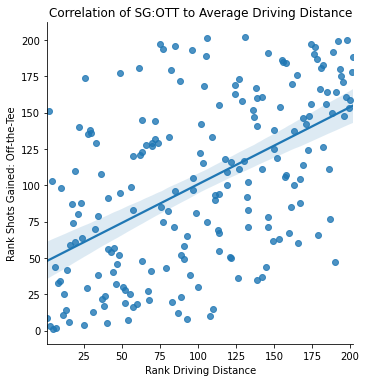

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import re

sg_dis = distance.merge(sg_ott, on='player_name', how='inner', suffixes=['_dis','_sg'])
sg_dis = sg_dis.merge(accuracy, on='player_name', how='left')
sg_dis = sg_dis.merge(smash_factor, on='player_name', how='left', suffixes=['_fw','_sf'])

# cols = ['player_name','distance','sg_ott','fw_hit','smash']
cols = [col for col in sg_dis.columns if 'rank_' in col]
sg_dis = sg_dis[cols].astype('float')

sns.lmplot(data=sg_dis, x='rank_dis', y='rank_sg')
plt.title('Correlation of SG:OTT to Average Driving Distance')
plt.xlabel('Rank Driving Distance')
plt.ylabel('Rank Shots Gained: Off-the-Tee')
sg_dis.corr()

In [11]:
import statsmodels.formula.api as sm

reg = sm.ols(formula='rank_sg ~ rank_dis + rank_fw + rank_sf', data=sg_dis).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                rank_sg   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     131.2
Date:                Tue, 21 Jun 2022   Prob (F-statistic):           7.92e-47
Time:                        17:01:03   Log-Likelihood:                -997.32
No. Observations:                 202   AIC:                             2003.
Df Residuals:                     198   BIC:                             2016.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -71.3576      9.380     -7.607      0.0

## Make Meta Json Files

In [7]:
reload(pga_data.mapping)
reload(pga_data.scrape)

mm = pga_data.mapping.make_meta()


In [8]:
import json
with open('pga_data/data_files/stat_meta.json') as f:
    stats = json.load(f)

In [36]:
print([d['stat name'] for d in stats if d['stat category']=='Off the Tee'][:20])
print([d['stat name'] for d in stats if d['stat category']=='Off the Tee'][-20:])
# set([d['stat category'] for d in stats])

['Driving Distance', 'Longest Drives', 'Driving Percentage 320+', 'Driving Percentage 300-320', 'Driving Percentage 300+', 'Driving Percentage 280-300', 'Driving Percentage 260-280', 'Driving Percentage 240-260', 'Driving Percentage <=240', 'Percentage of Yardage Covered by Tee Shots', 'Percentage of Yardage Covered by Tee Shots Par 4s', 'Percentage of Yardage Covered by Tee Shots Par 5s', 'Driving Accuracy Percentage', 'Rough Tendency', 'Left Rough Tendency', 'Right Rough Tendency', 'Left Rough Tendency (RTP Score)', 'Right Rough Tendency (RTP Score)', 'Fairway Bunker Tendency', 'Missed Fairway Percentage']
['Hit Fairway Percentage', 'Distance From Edge of Fairway', 'Distance From Center of Fairway', 'Left Tendency', 'Right Tendency', 'Good Drive Percentage', 'Total Driving', 'Ball Striking', 'Club Head Speed', 'Ball Speed', 'Smash Factor', 'Launch Angle', 'Spin Rate', 'Distance to Apex', 'Apex Height', 'Hang Time', 'Carry Distance', 'Carry Efficiency', 'Total Distance Efficiency', 'T

## Practice With SQL
